# Initial Preprocessing of UW-Madison Data
## (into 3D numpy array)

This file performs initial preprocessing of the UW-Madison dataset,
starting with the data as provided for the Kaggle competition,
and targeting 3D representation as a numpy array.

The reason to target 3D representation from the earliest preprocessing step are:
* Value clipping in 2D segmen done during preprocessing does not consider adjacent segments which may have values outside the curdrent image's range. This clipping approach will generate discontinuities in the depth dimension
* Autmentations are limited to 2D, so 3D representation learning does not benefit fromaugmentation in the third dimension.
* IoU/F1 score is strictly 2D, so the cost function does not reflect depth, and weight training does not benefit from depth.

`---`
The dataset comes from the UWMadison GI-Track Segmentation Kaggle Competition:
* https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/

The code here is largely copied/reused from an example provided by Kaggle competitor "AWSAF49"
* https://www.kaggle.com/code/awsaf49/uwmgi-mask-data

---

The input to this script is the dataset as provided for the competition
* 2.3G uw-madison-gi-tract-image-segmentation.zip

Once unzipped it includes
* MRI samples within a folder hierarchy which identifies the case (patient), day, and scan (slice).
* A single "training.csv" file that contains run-length encoding (RLE) of 3 segments of the brain, for a subset of the images.

An MRI is a set of scans that represent a 3D volume. Each scan is a 2D slice through the brain at a particular depth. Scans are in .png format and are a 16-bit grayscale image. Scans are co-located in the folder with it's peers for that MRI. 

A patient typically has several MRI samples, taken on different days.

---

This file performs the following:
* RLE segmentation data for [large_bowel, small_bowel, stomach] is read and used to generate a 3D mask of dimensions [H,W,D] where H=heigh, W=width, and D=depth. Depth is the number of scans in the MRI. Each voxel is uint8 valued as:
* 0 (binary 000) -> no classes
* 1 (binary 001) -> class A
* 2 (binary 010) -> class B
* 3 (binary 011) -> class A, B
* 4 (binary 100) -> class C
* 5 (binary 101) -> class A, C
* 6 (binary 110) -> class B, C
* 7 (binary 111) -> class A, B, C

The masks are written to file as .npy format.
* Note that the above one-hot encoding does not present itself easily as RGB - so viewing the masks will require a bit more effort.

In addition the grayscale MRI images are also re-written - here the "slices" are merged into a 3D numpy representation and written to a .npy file.


# Import Libraries

In [18]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm.notebook import tqdm
tqdm.pandas()
import time
import copy
import joblib
import gc
from IPython import display as ipd
from joblib import Parallel, delayed

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [182]:
pd.set_option('display.max_colwidth', None)

# Weights & Biases

<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width="400" alt="Weights & Biases" />

In [19]:
import wandb
wandb.login()

# try:
#     from kaggle_secrets import UserSecretsClient
#     user_secrets = UserSecretsClient()
#     api_key = user_secrets.get_secret("WANDB")
#     wandb.login(key=api_key)
# except:
#     wandb.login(anonymous='must',relogin=True)
#     print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

True

# Utilities

In [20]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = np.asarray(mask_rle.split(), dtype=int)
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


# Metadata

In [21]:
def get_metadata(row):
    data = row['id'].split('_')
    case = int(data[0].replace('case',''))
    day = int(data[1].replace('day',''))
    slice_ = int(data[-1])
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

def path2info(row):
    path = row['image_path']
    data = path.split('/')
    slice_ = int(data[-1].split('_')[1])
    case = int(data[-3].split('_')[0].replace('case',''))
    day = int(data[-3].split('_')[1].replace('day',''))
    width = int(data[-1].split('_')[2])
    height = int(data[-1].split('_')[3])
    row['height'] = height
    row['width'] = width
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

# Mask

In [22]:
def id2mask(id_, df=None):
    idf = df[df['id']==id_]
    wh = idf[['height','width']].iloc[0]
    shape = (wh.height, wh.width, 3)
    mask = np.zeros(shape, dtype=np.uint8)
    for i, class_ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
        cdf = idf[idf['class']==class_]
        rle = cdf.segmentation.squeeze()
        if len(cdf) and not pd.isna(rle):
            mask[..., i] = rle_decode(rle, shape[:2])
    return mask

def rgb2gray(mask):
    pad_mask = np.pad(mask, pad_width=[(0,0),(0,0),(1,0)])
    gray_mask = pad_mask.argmax(-1)
    return gray_mask

def gray2rgb(mask):
    rgb_mask = tf.keras.utils.to_categorical(mask, num_classes=4)
    return rgb_mask[..., 1:].astype(mask.dtype)

# Image

In [23]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = img.astype('float32') # original is uint16
    img = (img - img.min())/(img.max() - img.min())*255.0 # scale image to [0, 255]
    img = img.astype('uint8')
    return img

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = [ "Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

# Read Case/Segmentation Data

In [24]:
df = pd.read_csv('/mnt/d/code_medimg_practice/data/train.csv')
# df = df.progress_apply(get_metadata, axis=1)
df = df.apply(get_metadata, axis=1)
df.head()

,id,class,segmentation,case,day,slice
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1
2,case123_day20_slice_0001,stomach,NaN,123,20,1
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2


# Merge in Paths to Images

In [25]:
paths = glob('/mnt/d/code_medimg_practice/data/train/*/*/*/*')
path_df = pd.DataFrame(paths, columns=['image_path'])
# path_df = path_df.progress_apply(path2info, axis=1)
path_df = path_df.apply(path2info, axis=1)
df = df.merge(path_df, on=['case','day','slice'])
df.head()

,id,class,segmentation,case,day,slice,image_path,height,width
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1,/mnt/d/code_medimg_practice/data/train/case123...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1,/mnt/d/code_medimg_practice/data/train/case123...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,1,/mnt/d/code_medimg_practice/data/train/case123...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2,/mnt/d/code_medimg_practice/data/train/case123...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2,/mnt/d/code_medimg_practice/data/train/case123...,266,266


# Check Mask

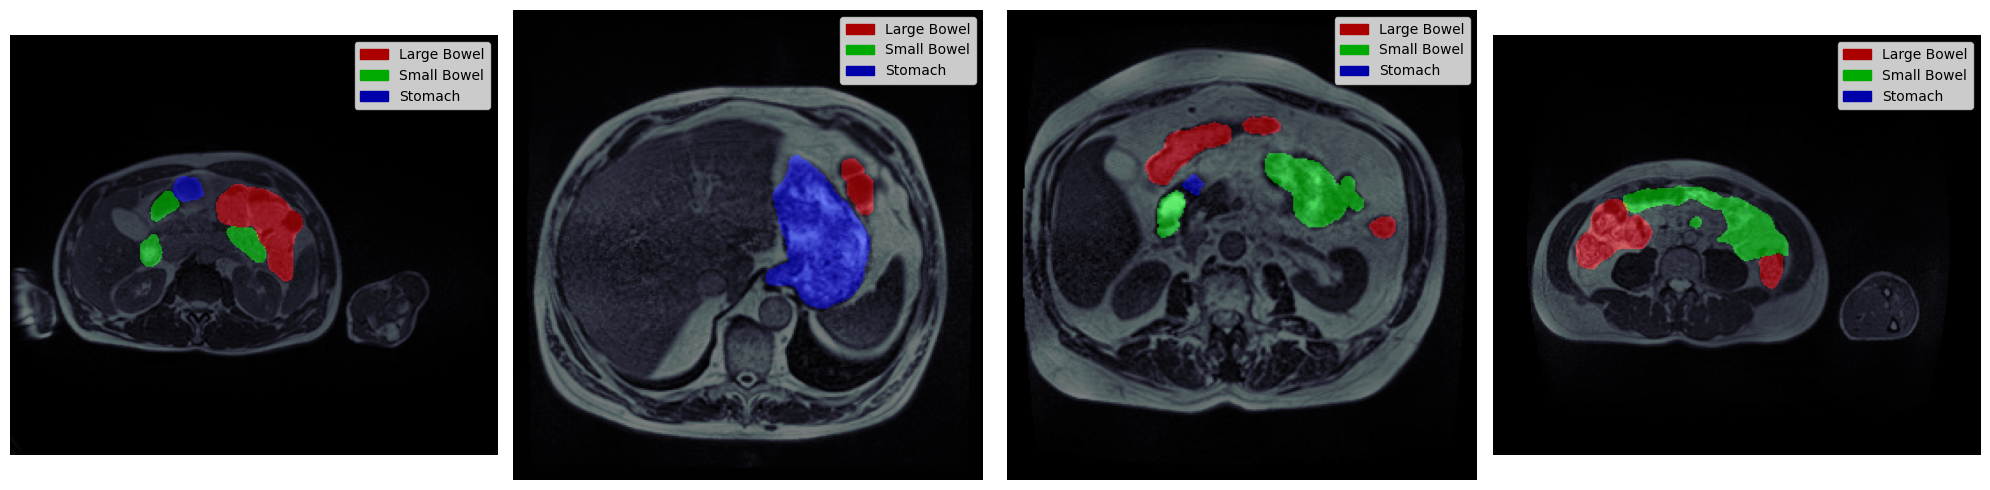

In [26]:
row=1; col=4
plt.figure(figsize=(5*col,5*row))
# the following line samples (row*col) unique IDs from that subset of the dataframe where "segmentation" is not N/A
# In other words - get four samples that have segmentation
for i, id_ in enumerate(df[~df.segmentation.isna()].sample(frac=1.0)['id'].unique()[:row*col]):
    img = load_img(df[df['id']==id_].image_path.iloc[0])
    mask = id2mask(id_,df=df)*255
    plt.subplot(row, col, i+1)
    i+=1
    show_img(img, mask=mask)
    plt.tight_layout()

# temporary - explore image and mask

in summary: df includes (3) entries for each image (a.k.a. case_id) - one for each segment
for example:
```
case34_day0_slice_0067
/mnt/d/code_medimg_practice/data/train/case34/case34_day0/scans/slice_0067_276_276_1.63_1.63.png
/mnt/d/code_medimg_practice/data/train/case34/case34_day0/scans/slice_0067_276_276_1.63_1.63.png
/mnt/d/code_medimg_practice/data/train/case34/case34_day0/scans/slice_0067_276_276_1.63_1.63.png
```
### Image
* An image is read from file using the load_img() function.
* That function performs only basic processing - converting from uint16 to uint8, and cropping values
* That function returns a numpy array of uint8 (between 0 and 255). Shape is variable.
* Image pixel values are a skewed mostly lower values.

### Mask
* A "mask" is generated using the id2mask function.
* That function:
  * generates a zero array having [height, width] same as the image, but with additional dimension of [3]
  * the pixels of that array are of type uint8
  * for each of the (3) segmentation RLE sequences ['large_bowel', 'small_bowel', 'stomach']
    * use the rle_decode to populate the array for that dimension 
  * the resulting array of shape [height, width, 3] having type uint8.
  * the resulting array has pixel values of [0,1] indicating pixel is of that segment type. The application performs *255 resulting in pixel values of [0, 255].




In [197]:
### explore...

# randomly sample from the dataframe, where segmentation is present, and choose the first
case_id = df[~df.segmentation.isna()].sample(frac=1.0)['id'].unique()[0]
print(case_id)

for y in (df[df['id']==case_id].image_path):
    print(y)

img = load_img(df[df['id']==case_id].image_path.iloc[0])
print(f"\ntype(img) {type(img)} img.shape {img.shape} type(img[0,0]) {type(img[0,0])}")
[print(y) for y in np.histogram(img)]


mask = id2mask(case_id, df=df)
print(f"\ntype(mask) {type(mask)} mask.shape {mask.shape} type(mask[0,0,0] {type(mask[0,0,0])}")
# [print(y) for y in np.histogram(mask[:,:,0])]
_ = [print(y) for y in np.histogram(mask[:,:,0])]
_ = [print(y) for y in np.histogram(mask[:,:,1])]
_ = [print(y) for y in np.histogram(mask[:,:,2])]



case124_day20_slice_0075
/mnt/d/code_medimg_practice/data/train/case124/case124_day20/scans/slice_0075_266_266_1.50_1.50.png
/mnt/d/code_medimg_practice/data/train/case124/case124_day20/scans/slice_0075_266_266_1.50_1.50.png
/mnt/d/code_medimg_practice/data/train/case124/case124_day20/scans/slice_0075_266_266_1.50_1.50.png

type(img) <class 'numpy.ndarray'> img.shape (266, 266) type(img[0,0]) <class 'numpy.uint8'>
[49415  3877  9862  3056  1684  1308  1056   372    86    40]
[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]

type(mask) <class 'numpy.ndarray'> mask.shape (266, 266, 3) type(mask[0,0,0] <class 'numpy.uint8'>
[69899     0     0     0     0     0     0     0     0   857]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[    0     0     0     0     0 70756     0     0     0     0]
[-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5]
[70357     0     0     0     0     0     0     0     0   399]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


# Initiate Weights&Biases project

In [28]:
# Initialize WANDB project
run = wandb.init(project='uwmgi-mask-data', 
                 config={},
#                  anonymous=anonymous,
                 name=f"01b_initial_preprocessing_to_3d_npy",
                )
# Columns for wandb table
columns=["id", "case", "day", "slice", "empty", "image"]
# Initialize table
table = wandb.Table(columns=columns)
# Labels for mask
class_labels = {
#     0:"Background",
    1:"Large Bowel",
    2:"Small Bowel",
    3:"Stomach",
}

# Binary Mask Set to Encoded Mask
This function takes in 3 binary masks A, B, C and returns a single encoded mask.
The output encoding considers that a pixel may be considered more than one class...
```
input:  np array of size [H,D,3] of ulong8 having value [0 or 1]
output: np array of size [H,D]   of ulong8 having value (array[2]<<2 + array[1]<<1 + array[0]) where "<<" is bitwise shift left

  * Input:                  Output:
  * no classes            0 (binary 000)
  * class A = 1           1 (binary 001)
  * class B = 1           2 (binary 010)
  * class A, B = 1        3 (binary 011)
  * class C = 1           4 (binary 100)
  * class A, C = 1        5 (binary 101)
  * class B, C = 1        6 (binary 110)
  * class A, B, C = 1     7 (binary 111)
  ```

In [83]:
def encode_mask_set(mask_in):
    result = \
        np.left_shift(mask_in[:,:,2], 2) + \
        np.left_shift(mask_in[:,:,1], 1) + \
        np.left_shift(mask_in[:,:,0], 0)
    return result

# 2D Array Set to MRI Sample
This function takes in a list of 2D images and stacks them into a 3D representation.
```
input: a list of D numpy arrays having dimension [H, W]
output: a 3D numpy array having dimensions [H, W, D]
```

In [75]:
def stack_2d_np_images_to_3d_np(images):
    return np.stack(images, axis=-1)

# Write Mask

In [32]:
NO_EMPTY = True

In [55]:
# case = case122_day24_slice_0070

tmp_df = df.copy()
print(f"NO_EMPTY={NO_EMPTY}")
if NO_EMPTY:
    tmp_df = tmp_df[~df.segmentation.isna()]
ids = tmp_df['id'].unique()

NO_EMPTY=True


In [66]:
id_ = ids[0]
idf = df[df['id']==id_]
mask = id2mask(id_, df=df)
mask.shape

(266, 266, 3)

In [77]:
result = binary_mask_set_to_encoded_mask(mask)


In [67]:
# result = \
#     np.left_shift(mask[:,:,2], 2) + \
#     np.left_shift(mask[:,:,1], 1) + \
#     np.left_shift(mask[:,:,0], 0)


In [78]:
result.shape

(266, 266)

In [79]:
[print(x) for x in np.histogram(mask[:,:,2])]
[print(x) for x in np.histogram(mask[:,:,1])]
[print(x) for x in np.histogram(mask[:,:,0])]

[70600     0     0     0     0     0     0     0     0   156]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[    0     0     0     0     0 70756     0     0     0     0]
[-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5]
[    0     0     0     0     0 70756     0     0     0     0]
[-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5]


[None, None]

In [80]:
[print(x) for x in np.histogram(result)]


[70600     0     0     0     0     0     0     0     0   156]
[0.  0.4 0.8 1.2 1.6 2.  2.4 2.8 3.2 3.6 4. ]


[None, None]

In [ ]:
def get_mask_set(id):

In [ ]:
def get_encoded_mask(mask_set):
    return True

In [ ]:
# work in progress...
def get_3d_mask(mri_id, df):
    idf = df[df['id']==mri_id]

 image_path = idf.image_path.iloc[0]
#     img = load_img(image_path) # load image
#     # mask_path = image_path.replace('/kaggle/input/','/tmp/png/')
#     mask_path = image_path.replace(
#         '/mnt/d/code_medimg_practice/data/train/',
#         '/mnt/d/code_medimg_aneja_lab/data_uwmadison_01_preprocessed/tmp/png/')





    image_id_list = df[df.id==mri_id].decompress

    encoded_masks = []
    for image_id in image_id_list:
        mask_2d_set = get_mask_set(image_id)
        mask_3d = encode_mask_set(mask_2d_set)
        encoded_masks.append(mask_3d)        
    rtn = np.stack(encoded_masks, axis=-1)
    return rtn

In [183]:
df

,id,class,segmentation,case,day,slice,image_path,height,width
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1,/mnt/d/code_medimg_practice/data/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1,/mnt/d/code_medimg_practice/data/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,1,/mnt/d/code_medimg_practice/data/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2,/mnt/d/code_medimg_practice/data/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2,/mnt/d/code_medimg_practice/data/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png,266,266
...,...,...,...,...,...,...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN,30,0,143,/mnt/d/code_medimg_practice/data/train/case30/case30_day0/scans/slice_0143_266_266_1.50_1.50.png,266,266
115484,case30_day0_slice_0143,stomach,NaN,30,0,143,/mnt/d/code_medimg_practice/data/train/case30/case30_day0/scans/slice_0143_266_266_1.50_1.50.png,266,266
115485,case30_day0_slice_0144,large_bowel,NaN,30,0,144,/mnt/d/code_medimg_practice/data/train/case30/case30_day0/scans/slice_0144_266_266_1.50_1.50.png,266,266
115486,case30_day0_slice_0144,small_bowel,NaN,30,0,144,/mnt/d/code_medimg_practice/data/train/case30/case30_day0/scans/slice_0144_266_266_1.50_1.50.png,266,266


In [95]:
df.iloc[0]

id                                       case123_day20_slice_0001
class                                                 large_bowel
segmentation                                                  NaN
case                                                          123
day                                                            20
slice                                                           1
image_path      /mnt/d/code_medimg_practice/data/train/case123...
height                                                        266
width                                                         266
Name: 0, dtype: object

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
 3   case          115488 non-null  int64 
 4   day           115488 non-null  int64 
 5   slice         115488 non-null  int64 
 6   image_path    115488 non-null  object
 7   height        115488 non-null  int64 
 8   width         115488 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 7.9+ MB


In [102]:
df.describe(include='all')

,id,class,segmentation,case,day,slice,image_path,height,width
count,115488,115488,33913,115488.000000,115488.000000,115488.000000,115488,115488.000000,115488.000000
unique,38496,3,33899,NaN,NaN,NaN,38496,NaN,NaN
top,case123_day20_slice_0001,large_bowel,12629 10 12894 12 13158 15 13423 17 13688 19 1...,NaN,NaN,NaN,/mnt/d/code_medimg_practice/data/train/case123...,NaN,NaN
freq,3,38496,2,NaN,NaN,NaN,3,NaN,NaN
mean,NaN,NaN,NaN,84.812968,13.354946,71.502494,NaN,279.029925,293.618454
std,NaN,NaN,NaN,46.487124,10.397365,41.492367,NaN,20.050935,42.688045
min,NaN,NaN,NaN,2.000000,0.000000,1.000000,NaN,234.000000,234.000000
25%,NaN,NaN,NaN,42.000000,0.000000,36.000000,NaN,266.000000,266.000000
50%,NaN,NaN,NaN,85.000000,16.000000,71.000000,NaN,266.000000,266.000000
75%,NaN,NaN,NaN,129.000000,21.000000,107.000000,NaN,310.000000,360.000000


In [103]:

df.head(1)

,id,class,segmentation,case,day,slice,image_path,height,width
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1,/mnt/d/code_medimg_practice/data/train/case123...,266,266


In [226]:
foo = np.zeros((1,1,1), dtype=np.uint8)
foo

array([[[0]]], dtype=uint8)

In [228]:
gonza == None

NameError: name 'gonza' is not defined

In [227]:
for x in range(5):
    print(x)
    bar = np.zeros((2,2))
print(bar)

0
1
2
3
4
[[0. 0.]
 [0. 0.]]


In [244]:
# generate 3D masks

SLICE_INDEXING_BASE = 1  # seriously - the slice index is 1-based... doh

case_day_groups = df.groupby(['case', 'day'])[['slice', 'class', 'image_path', 'id', 'height', 'width']]
# grouped_df.first()
# i = 0
# groups_c_d.describe()
# grouped_df.count()
for (case, day), case_day_group in case_day_groups:
    print(f'case {case} day {day}')
    height = case_day_group.iloc[0].height
    width = case_day_group.iloc[0].width
    depth = case_day_group.id.count() // 3
    # print(f"height {height} width {width} depth {depth}")
    mri_mask = np.zeros((height, width, depth), dtype=np.uint8)

    image_groups = case_day_group.groupby(['id'])[['class', 'slice', 'image_path']]
    for (id), image_group in image_groups:
        # print(id)
        mask_onehot = id2mask(id, df=df)
        mask_encoded = encode_mask_set(mask_onehot)
        slice = image_group.slice.iloc[0] - SLICE_INDEXING_BASE
        # print(slice)
        mri_mask[:, :, slice] = mask_encoded
    
    # print(np.histogram(mri_mask))

    mask_path2 = image_path.replace(
        '/mnt/d/code_medimg_practice/data/train/',
        '/mnt/d/code_medimg_aneja_lab/data_uwmadison_01b_preprocessed/tmp/np/').replace('.png','.npy')
    
    mask_folder2 = mask_path2.rsplit('/',1)[0]
    os.makedirs(mask_folder2, exist_ok=True)
    np.save(mask_path2, mask)
  

In [81]:
def save_mask(id_,df=None, count=0):

    idf = df[df['id']==id_]
    mask_3 = id2mask(id_, df=df)  # mask is [height, width, 3] and values are [0, 1]
    mask = binary_mask_set_to_encoded_mask(mask_3)

    image_path = idf.image_path.iloc[0]
    # img = load_img(image_path) # load image
    # mask_path = image_path.replace('/kaggle/input/','/tmp/png/')
    mask_path = image_path.replace(
        '/mnt/d/code_medimg_practice/data/train/',
        '/mnt/d/code_medimg_aneja_lab/data_uwmadison_01b_preprocessed/np/')

    mask_folder = mask_path.rsplit('/',1)[0]
    os.makedirs(mask_folder, exist_ok=True)
    np.save(mask_path, mask)
    return mask_path

In [82]:
# def save_mask(id_,df=None, count=0):
#     # print(count)
#     # print(df.head())
#     # assert False, "hold up"
    
#     idf = df[df['id']==id_]
#     mask = id2mask(id_, df=df)  # mask is [height, width, 3] and values are [0, 1] 
#     image_path = idf.image_path.iloc[0]
#     img = load_img(image_path) # load image
#     # mask_path = image_path.replace('/kaggle/input/','/tmp/png/')
#     mask_path = image_path.replace(
#         '/mnt/d/code_medimg_practice/data/train/',
#         '/mnt/d/code_medimg_aneja_lab/data_uwmadison_01_preprocessed/tmp/png/')

#     mask_folder = mask_path.rsplit('/',1)[0]
#     os.makedirs(mask_folder, exist_ok=True)
#     cv2.imwrite(mask_path, mask*255, [cv2.IMWRITE_PNG_COMPRESSION, 1]) # convert mask values to [0, 255] and write as .png
#     # mask_path2 = image_path.replace('/kaggle/input/','/tmp/np/').replace('.png','.npy')
#     mask_path2 = image_path.replace(
#         '/mnt/d/code_medimg_practice/data/train/',
#         '/mnt/d/code_medimg_aneja_lab/data_uwmadison_01_preprocessed/tmp/np/').replace('.png','.npy')
    
#     mask_folder2 = mask_path2.rsplit('/',1)[0]
#     os.makedirs(mask_folder2, exist_ok=True)
#     np.save(mask_path2, mask*255) # convert mask values to [0, 255] and write as .npy
#     # log some images in WandB table
#     if count<=NUM_LOG:
#         img = cv2.resize(img, dsize=(160, 192), interpolation=cv2.INTER_AREA)
#         mask = cv2.resize(mask, dsize=(160, 192), interpolation=cv2.INTER_NEAREST)
#         table.add_data(id_, 
#                        idf.case.iloc[0], 
#                        idf.day.iloc[0],
#                        idf.slice.iloc[0],
#                        int(mask.sum()==0),
#                        wandb.Image(img, masks={
#     #         "predictions" : {
#     #             "mask_data" : prediction,
#     #             "class_labels" : class_labels
#     #         },
#             "ground_truth" : {
#                 "mask_data" : rgb2gray(mask), # (height, width, 3) => (height, width) => may lose overlap data
#                 "class_labels" : class_labels
#             }}))
#     return mask_path

In [73]:
tmp_df = df.copy()
print(f"NO_EMPTY={NO_EMPTY}")
if NO_EMPTY:
    tmp_df = tmp_df[~df.segmentation.isna()]
ids = tmp_df['id'].unique()
# Save Mask
# _ = Parallel(n_jobs=-1, backend='threading')(delayed(save_mask)(id_, df=tmp_df, count=i)\
#                                              for i, id_ in enumerate(tqdm(ids, total=len(ids))))
# for i, id_ in enumerate(ids):
#     save_mask(id_, df=tmp_df, count=i)
# _ = Parallel(n_jobs=-1, backend='threading')(delayed(save_mask)(id_, df=tmp_df, count=i)\
#                                             for i, id_ in enumerate(tqdm(ids)))
_ = Parallel(n_jobs=-1, backend='threading')(delayed(save_mask)(id_, df=tmp_df, count=i)\
                                            for i, id_ in enumerate(ids))

NO_EMPTY=True
